#### This notebook allows the application of the 3 algorithms to individual days of MUR data. There is a pipeline for downloading MUR data for individual days and the consequent application of the 3 algorithms to this data. 

In [12]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import os
from pathlib import Path
from numpy import nanmedian
import scipy
import scipy.signal
import math
from numpy.fft import fft2
import cv2
import matplotlib
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
from datetime import date, timedelta
import wget
plt.rcParams["figure.figsize"] = 12, 10
%matplotlib inline

In [4]:
yesterday = (date.today() - timedelta(days=2)).strftime('%Y%m%d')

In [5]:
'sst_' + yesterday + '.nc'

'sst_20220627.nc'

## Download MUR data

The following functions and code allow to download data from MUR, which will be saved as netCDF files in the data directory

In [6]:
def boundingindex(dmin, dint, boundary0, boundary1):
    """
    get boundaries values to download the data already cropped
    """
    inx0 = max(int(floor((boundary0 - dmin) / dint)), 0)
    inx1 = max(int(floor((boundary1 - dmin) / dint)), 0)
    if inx0 > inx1:
        atemp = inx0
        inx0 = inx1
        inx1 = atemp
    return [inx0, inx1]

In [7]:
def get_mur_params(lon_box, lat_box):
    """
    Check sample file to get parameters for sst
    """
    mur_ncin = open_url(
        'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/002/20180102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
    lon = mur_ncin['lon']
    lat = mur_ncin['lat']
    lon_step = np.mean(np.diff(lon))
    lat_step = np.mean(np.diff(lat))
    [mur_i0, mur_i1] = boundingindex(lon[0][0].data, lon_step, lon_box[0], lon_box[1])
    [mur_j0, mur_j1] = boundingindex(lat[0][0].data, lat_step, lat_box[0], lat_box[1])

    return mur_i0, mur_i1, mur_j0, mur_j1

In [ ]:
get_mur_params([-19, -5], [35, 45])

In [8]:
def download_from_url(fileget, filenameout, replace, printiti):
    """
    function that tries to download data from "fileget" if the data didn't previously exist,
    the user asked to replace the old data, or the file has 0 bytes
    """
    exists = os.path.exists(filenameout)
    if exists:
        file_size = os.path.getsize(filenameout)
    else:
        file_size = 1
    if (not exists) or (replace and exists) or (file_size == 0):
        if exists:
            os.remove(filenameout)
        try:
            return wget.download(fileget, out=filenameout, bar=None)
        except Exception as e:
            if printiti:
                print(e)
                print("Error downloading")
                print("Download error url: " + fileget)
            return e
    return filenameout

In [9]:
def download_sst(path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    
    """
    This function allow us to download a specific day of data. We need to provide 
    the path where it will be downloaded and the parameters (mur_j0, mur_j1, muri0, muri1). We can get these parameters
    with the get_mur_params function that receives as parameter the range of longitude and latitude values
    we want for our SST data
    """
    
    opendap_dir = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/' + str(
        date.year) + '/'
    filename = opendap_dir + "{0:0>3}".format(str(date.dayofyear)) + '/' + date.strftime(
        "%Y%m%d") + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4'
    filenameout = path + "sst_" + date.strftime("%Y%m%d") + '.nc'
    fileget = filename + '?analysed_sst[0:1:0][' + str(mur_j0) + ':1:' + str(mur_j1) + '][' + str(mur_i0) + ':1:' + str(
        mur_i1) + ']'
    download_from_url(fileget, filenameout, replace, 1)
    return

In [10]:
def download_sst_thread(data_range, sst_path, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    
    """
    This function allow us to download several days of data simultaneously. We just need to provide the data_range,
    the path where it will be downloaded and the parameters (mur_j0, mur_j1, muri0, muri1). We can get these parameters
    with the get_mur_params function that receives as parameter the range of longitude and latitude values
    we want for our SST data
    """
    
    for date in tqdm(data_range, desc='SST', file=sys.stdout):
        download_sst(sst_path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace)
    return

In [ ]:
#Import several days simultaneously
download_sst_thread(data_range = pd.date_range(start=pd.to_datetime('20190901'), end=pd.to_datetime('20190930')), sst_path='../data/', mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

In [13]:
# Download individual days of MUR data
download_sst(path = "../data/", date = pd.to_datetime('20220627'), mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

## Import Data


In the data directory there are several netCDF files with MUR data.

In [14]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #if we are importing MUR data, rename columns and convert temperature to Celsius
    if data.startswith('mur') or data.startswith('sst'):   #the downloaded individual day mur data name starts with sst
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [15]:
june27_2022 = get_data('sst_20220627.nc')

# Canny Algorithm

In [59]:
def canny_front_detection_1day(df, thresh_min=120, thresh_max=220, apertureSize=5, sigma=5):
    
    """
    This function receives a dataframe with MUR data for a individual day and plots the result
    of the aplication of the Canny Algorithm from OpenCV. 
    For visualization purposes, one can change the minimum and maximum threshold.
    One can also apply a gaussian filter with a certain sigma value to reduce noise of the image
    """

    # Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
    sst = df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    #Convert Temperature values to uint8 format with values in the range of 0-255
    sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
    sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    #in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
    sst_final = gaussian_filter(sst_final, sigma=sigma)   

    #to define the extent of the plot
    lat = df['latitude'].to_numpy()   
    lon = df['longitude'].to_numpy()
    lat = np.unique(lat).round(3)
    lon = np.unique(lon).round(3)
    
    #apply the canny algorithm and plot the image with the edges
    canny = cv2.Canny(sst_final, thresh_min, thresh_max, apertureSize=apertureSize, L2gradient=False)

    #Apply a mask for the continental zone:
    mask = np.isnan(np.flipud(sst))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
    #Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    canny_mask =np.ma.masked_where(mask_dilated==255, canny)   #Mask an array where a condition is me
    
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 1)
    newcolor = viridis(np.linspace(0,1,10))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    plt.figure()
    plt.rcParams["figure.figsize"] = (12, 10)
    plt.imshow(canny_mask, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]])
    plt.title("Canny Algorithm (MUR)", fontsize=25)
    
    return canny_mask

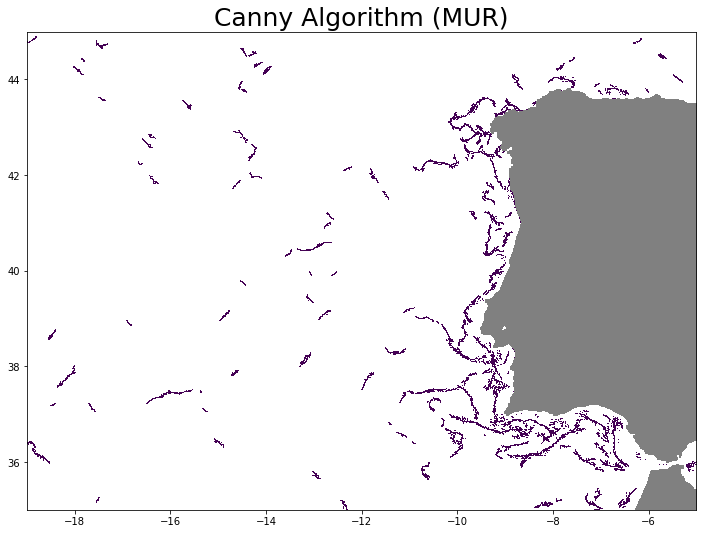

In [60]:
canny_frente = canny_front_detection_1day(june27_2022)

In [25]:
np.unique(canny_frente)

masked_array(data=[0, --, 255, ..., --, 255, --],
             mask=[False,  True, False, ...,  True, False,  True],
       fill_value=999999,
            dtype=uint8)

# Belkin O'Reilly Algorithm (BOA)

## Functions for the application of the Belkin O'Reilly Algorithm (BOA)

In [26]:
def filt5(lon, lat, ingrid, nodata=np.nan):
    """
    Find peaks in 5 directions. Flag as 5
    Finds maximum of a 5x5 sliding window. If the central pixel is the maximum, this is flagged as a one.
    All other pixels are flagged as zero.
    """
    
    nodatidx = ingrid.flatten()*np.nan     # creates 1D array with as much values as the matrix ingrid, with NANs
    outgrid = np.zeros(ingrid.shape)       # outgrid is a matrix with the shape of ingrid, full of Zeros

    l1 = len(lat)
    l2 = len(lon)

    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            subg = ingrid[(i-3):(i+2), (j-3):(j+2)]   #return the last 5 rows of the last 5 columns of the matrix
            if np.isnan(subg).sum()==25:              #if all values in submatrix subg are null values:
                outgrid[i,j] = 0
            else:
                vec = np.array(subg).T.flatten()    # array with values of the transpose subg matrix
                ma = np.argmax(subg.flatten())      # index with the maximum value of subg array
                mi = np.argmin(subg.flatten())      # index with the minimum value of subg array
                
                if ma==12 or mi==12:     #if ma or mi is the middle value of 5X5 matrix (if the central pixel is the maximum)
                    outgrid[i-1,j-1] = 1      #flagged as 1
                else:
                    outgrid[i-1,j-1] = 0      #all other pixels are flagged as 0
    
    return outgrid

In [27]:
def filt3(lon, lat, ingrid, grid5):
    """
    Find peaks in 3 directions. FLag as 3
    Returns a median smoothed grid of satellite data
    """
    
    outgrid = ingrid*0   # matrix of 0s with shape of ingrid matrix
    l1 = len(lat)
    l2 = len(lon)
    
    for i in range(3, l1-1):   
        for j in range(3, l2-1):
            if (grid5[i,j]==0):
                subg = ingrid[(i-2):(i+1), (j-2):(j+1)]       # submatrix subg (3x3) 
                if np.isnan(subg).sum()==9:                   # if all values in submatrix subg (3x3) are null values:
                    outgrid[i-1,j-1] = ingrid[i-1,j-1]
                else:
                    vec = np.array(subg).T.flatten()          # array with values of the transpose subg matrix
                    ma = np.argmax(subg.flatten())            # index with the maximum value of subg array
                    mi = np.argmin(subg.flatten())            # index with the minimum value of subg array
                    
                    if (ma==4 or mi==4):                      #if ma or mi is the middle value of 3X3 matrix
                        outgrid[i-1,j-1] = nanmedian(subg)    # median while ignoring NaNs.
                    else:
                        outgrid[i-1,j-1] = ingrid[i-1,j-1]
            
            else:
                outgrid[i-1,j-1] = ingrid[i-1,j-1]
                
    return outgrid

In [28]:
def boa(lon, lat, ingrid, nodata = np.nan, direction = False):
    
    def filter2(x, filt):
        """
        Workhorse filter from EBImage. Modified so we don't need colorspace and other annoying requirements
        """
        
        dx = x.shape                          
        df = filt.shape  
        
        if (df[0]//2 == 0) or (df[1]//2 == 0):
            sys.exit('dimensions of "filter" matrix must be odd')
        if (dx[0] < df[0]) or (dx[1] < df[1]):
            sys.exit("dimensions of 'x' must be bigger than 'filter'")
            
        cx = tuple(elem//2 for elem in dx)    
        cf = tuple(elem//2 for elem in df)    

        wf = np.zeros(shape=dx)                                   #matrix with zeros with shape of x

        wf[cx[0]-cf[0]-1:cx[0]+cf[0], cx[1]-cf[1]-1:cx[1]+cf[1]] = filt    #put values of filt in middle of matrix wf

        wf = fft2(wf)                                      #apply the 2 dimensional discrete fourier transform                  
    
        dim_x = np.array(dx[0:2])
        dim_x =np.append(dim_x, math.prod(dx)/math.prod(dx[0:2]))     

        aux1 = np.arange(cx[0],dx[0]+1)
        aux2 = np.arange(1,cx[0])
        index1 = np.concatenate((aux1, aux2), axis=None)  
        index1 = index1-1   

        aux3 = np.arange(cx[1], dx[1]+1)
        aux4 = np.arange(1,cx[1])
        index2 = np.concatenate((aux3, aux4), axis=None) 
        index2 = index2-1   
        #this indices will be used to reorder values of matrix y
        
        y = (scipy.fft.ifft2(scipy.fft.fft2(x)*wf)).real

        y = np.array([[y[i][j] for j in index2] for i in index1])
        
        return y
    
#======================================================#
# Main BOA algorithm                                   
#======================================================#      
    gx = np.matrix([[-1,0,1],[-2,0,2],[-1,0,1]])        #filter in x
    gy = np.matrix([[1,2,1],[0,0,0],[-1,-2,-1]])        #filter in y
        
    np.nan_to_num(ingrid, nan=-9999, posinf=-9999, neginf=-9999)    #replace NaN and inf values with -9999
        
    grid5 = filt5(lon, lat, ingrid, nodata = nodata)
    grid35 = filt3(lon, lat, ingrid, grid5)

    # make an index of bad values and land pixels.
    grid35 = grid35.astype("float")
    grid35[grid35 == -9999]=np.nan
    naidx = np.isnan(grid35)        #matrix with shape of grid35 (True if value is nan, False otherwise)
    # convert these (True values of naidx) to zeros (in grid35) for smoothing purposes
    grid35[naidx]=0  

    # perform the smoothing (Sobel filter)  
    tgx = filter2(grid35, gx)
    tgy = filter2(grid35, gy)
        
    tx = tgx/np.nansum(abs(np.array(gx).flatten()))    
    ty = tgy/np.nansum(abs(np.array(gy).flatten()))    
    front = np.sqrt((tx**2)+(ty**2))                   

#======================================================#
# landmask and edge dilation
#======================================================#

    land = naidx*1
    land = land.astype("float")

    land[land==1] = np.nan
    land[~np.isnan(land)] = 1

    
#======================================================#
# landmask and edge dilation using raster!
#======================================================#

    l2=lon.size    
    l1=lat.size

    midx = land*np.nan

    midx[5:(l1-2), 5:(l2-2)] = 1

    land = np.multiply(land, midx)
    
    
    ssr = np.flip(front.T, 0)
    

    #Apply a sliding window kernell to the land matrix
    mask = scipy.signal.convolve2d(np.flip(land.T, 0), np.array([0,0,0,0,1,0,0,0,0]).reshape(3,3), boundary='symm', mode='same')

    matrix_front =  mask * np.flip(front.T, 0)         #matrix of mask raster file * matrix of ssr raster file


    
    if direction==True:
#   ************************************
#   *** Calculate Gradient Direction ***
#   ************************************
        
        n = ingrid.size                                      #nr of elements of the grid matrix
        grid_shape = ingrid.shape

        GRAD_DIR = np.zeros(n)                               #matrix of zeros with shape of ingrid matrix

        for i in range(n):
            GRAD_DIR[i] = math.atan2(tgy.flatten()[i], tgx.flatten()[i])
    
        GRAD_DIR = GRAD_DIR*180/math.pi                      #change radians to degrees

        OK = np.where(GRAD_DIR < 0)

        OK = np.array(OK)

        if OK.size >1:
            GRAD_DIR[OK] = 360 - abs(GRAD_DIR[OK])    #Adjust to 0-360 scheme (make negative degrees positive)
    
        GRAD_DIR = (360 - GRAD_DIR + 90) % 360     #Convert degrees so that 0 degrees is North and East is 90 degrees
        GRAD_DIR = GRAD_DIR.reshape(grid_shape)
        
        
        grad_dir = np.flip(GRAD_DIR.T, 0)


        # create array grdir (result from multiplication of grad_dir_matrix and mask_matrix (its the conv matrix))
        grdir_matrix = np.flip(GRAD_DIR.T, 0)*mask


        dic = {'grdir': grdir_matrix, 'front': matrix_front}
        
    else:
        matrix_front

        
    return matrix_front

In [61]:
def BOA_aplication(df):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise don't). 
    """
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
    ingrid = np.array(df['thetao']).reshape(len(lat), len(lon))
    
    front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    front = np.flip(front, axis=0)
    front = np.array([[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)])
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 1)
    newcolor = viridis(np.linspace(0,1,10))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    
    plt.imshow(front, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]])
    #limits of x and y axis for the MUR data
    plt.xlim([-18.95, -5])
    plt.ylim([35.05, 45])
    plt.title("BOA (MUR)", fontsize=20)
    
    return front


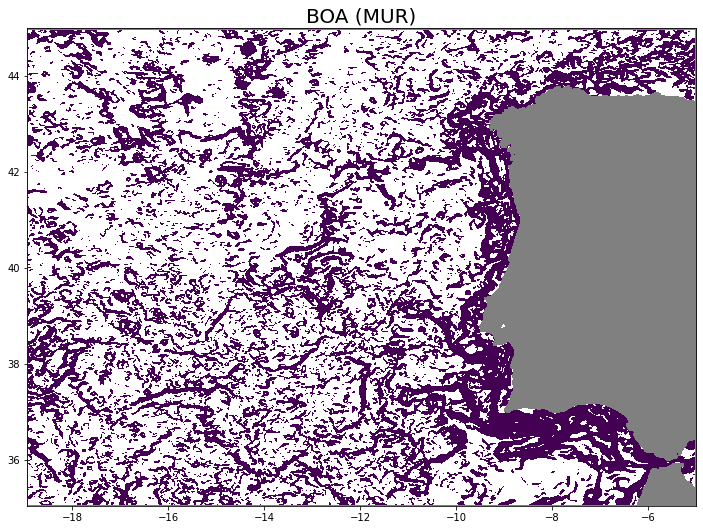

In [62]:
boa_frente = BOA_aplication(june27_2022)

In [32]:
np.unique(boa_frente)

array([3.05017005e-15, 3.05177604e-15, 3.33501518e-15, ...,
                  nan,            nan,            nan])

In [52]:
np.histogram(np.isfinite(boa_frente))


(array([ 296570,       0,       0,       0,       0,       0,       0,
              0,       0, 1105831]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

# Cayulla-Cornillon Algorithm

In [33]:
def getFrontInWindow(w, head, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, 
                     minGlobalPopCohesion, corners):
    
    """
    This functions detects fronts in slidding windows. If a front is detected, the function will return
    2 1D arrays (x and y) with the coordinate values corresponding to the location of the front.
    """
    
    #empty arrays de xdata, ydata e z
    xdata = np.array([])
    ydata = np.array([])
    z = np.array([])
    exitType=0
    
    #mask is an array with the same shape of w, that is 1 if in that index position w = np.nan and 0 otherwise
    mask = np.isnan(w).astype('int')  
    haveNaNs = np.any(mask[:]).astype('int')  #haveNaNs=1 if mask has 1s (that correspond to NaNs in matrix w)
    n_NaNs=0
    
    
    if haveNaNs:
        n_NaNs = sum(mask.flatten()[:])                 # count nr of 1s (NaNs in matrix w) that there are
        if (n_NaNs/len(w.flatten())>0.5):               #window can't have more than 50% of its pixels as NaNs
            exitType=-1
            return None,None,None,exitType  
        
    mi_ma = [np.nanmin(w), np.nanmax(w)]                          #array with minimum and maximum value of w
    n = math.ceil((mi_ma[1]-mi_ma[0])/0.02)                       #number of bins
    bins = np.arange(mi_ma[0], mi_ma[1], 0.02)                    #to define the bins sequence 
    [y, xout] = np.histogram(w[:], bins, mi_ma)                   #y->frequency counts, Xout->bin location
    xout = np.mean(np.vstack([xout[0:-1],xout[1:]]), axis=0)      #xout to be relative to the centers of the bins
    
    
    thresValue = xout[0]        
    totalCount = len(w.flatten()) - n_NaNs                         #nr of non NaN pixels 
    threshPopACount = 0
    threshSeparation = -1
    threshPopAMean = 0
    threshPopBMean = 0
    
    w[mask==1] = 0                      #Replace NaNs with 0's (when mask is 1 replace values of array w for 0)
    totalSum = sum(w.flatten())                      #sum of values of matrix w
    totalSumSquares = sum(w.flatten()*w.flatten())   #sum of the squares of the values of w
    
    #In this for loop we are going to discover which line is going to make the best separation between the average
    # of population on the left and on the right (A and B) - and that is going to be the thresValue
    for k in range(1,n-1):     #ignore the first and last candidates (senão seria de 0 a n)
        popASum = sum(y[0:k+1] * xout[0:k+1])    
        popBSum = sum(y[k+1:] * xout[k+1:])  
        popACount = sum(y[0:k+1])     #sum of frequencies (y) from populationA
        popBCount = sum(y[k+1:])      #sum of frequencies (y) from populationB
    
        popAMean = popASum/popACount
        try:                                  #to avoid the zerodivisionerror that was poping up 
            popBMean = popBSum/popBCount
        except ZeroDivisionError:
            popBMean = 0
        separation = popACount * popBCount * (popAMean - popBMean) * (popAMean - popBMean)
        if separation>threshSeparation:
            threshSeparation = separation
            thresValue = xout[k]
            threshPopACount = popACount
            threshPopAMean = popAMean
            threshPopBMean = popBMean
            
         
    #abort in case the proportion of population A is less that a certain minimum
    if (threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None, None, exitType  
    
    #abort in case the proportion of population B is less that a certain minimum
    if (1.0 - threshPopACount / totalCount < minPopProp):
        exitType = 1
        return None,None,None, exitType  
    
    #abort this window if the difference in the populations means is less than a minimum value
    if (threshPopBMean - threshPopAMean < minPopMeanDiff):   
        exitType = 2
        return None,None,None,exitType  
    
    #Calculate the criterion function THETA (TAUopt) in page 72 of the paper
    totalMean = totalSum/totalCount
    variance = totalSumSquares - (totalMean * totalMean * totalCount)
    theta = threshSeparation / (variance * totalCount)
    if (theta < minTheta):         #abort if theta is lower than a certain minimum  
        exitType = 3
        return None,None,None,exitType  
    
#Cohesion - now that we know the separation value. Based on this value we will check the matrix element by 
#element, and check whether is bigger or lower than the separation  
#we check if it's bigger bellow or to the right (when its bigger we add from one side, when its lower add to the other)
#Count the nr of times a population A cell is immediately adjacent to another popA cell and the same for popB
# A cell can be adjacent on 4 sides. Count only 2 of them (bottom and right side) because doing all 4 would be
#redundant. Do not count diagonal neighbors
    countANextToA = 0
    countBNextToB = 0
    countANextToAOrB = 0
    countBNextToAOrB = 0
    [n_rows, n_cols] = w.shape
    for col in range(0, n_cols-1):
        for row in range(0, n_rows-1):
            if (haveNaNs & (mask[row, col] | mask[row+1, col] | mask[row, col+1])):
                continue
                         
            #examine the bottom neighbor
            if (w[row, col] <= thresValue):                  #if matrix pixel < than the element of separation
                countANextToAOrB = countANextToAOrB + 1      #increase by 1 countANextToAOrB
                if (w[row+1, col] <= thresValue):            #if pixel of bottom row < than separation
                    countANextToA = countANextToA + 1        #increase countANextToA
            else:                                            #if pixel > than separation 
                countBNextToAOrB = countBNextToAOrB + 1      #increase countBNextToAOrB
                if (w[row+1, col] > thresValue):             #if pixel of bellow row > separation
                    countBNextToB = countBNextToB + 1        #increase countBNextToB
                         
                         
            # Examine the right neighbor
            if (w[row, col] <= thresValue):                     #if matrix pixel < separation      
                countANextToAOrB = countANextToAOrB + 1         # increase countANextToAOrB
                if (w[row, col+1] <= thresValue):               #if right pixel < separation
                    countANextToA = countANextToA + 1           # increase countANextToA
            else:                                               #if matrix pixel > separation
                countBNextToAOrB = countBNextToAOrB + 1         #increase countBNextToAOrB
                if (w[row, col+1] > thresValue):                #if right pixel > separation
                    countBNextToB = countBNextToB +1            # increase countBNextToB
                         
                         
    popACohesion = countANextToA / countANextToAOrB
    popBCohesion = countBNextToB/ countBNextToAOrB
    globalCohesion = (countANextToA + countBNextToB) / (countANextToAOrB + countBNextToAOrB)
    
    #These ifs are in case of errors (parameters below certain limits)
    if (popACohesion < minSinglePopCohesion):
        exitType = 4
        return None, None,None,exitType  
                         
    if (popBCohesion < minSinglePopCohesion):
        exitType = 4
        return None, None, None,exitType  
                         
    if (globalCohesion < minGlobalPopCohesion):
        exitType = 4
        return None, None, None,exitType  
                         
                         
    #OK if we reach here we have a front. Compute its contour
    X = np.linspace(head[0], head[1], n_cols)    
    Y = np.linspace(head[2], head[3], n_rows)
    if (corners.size == 0):
        w = w.astype('double')    
        if haveNaNs:
            w[w==0] = np.nan      # Need to restore the NaNs to not invent new contours around zeros
        
        c = plt.contour(X, Y, w, [thresValue])    #Create and store a set of contour lines or filled regions.
    else:
        #the 4 corners have these indices [17,32,17,32; 17,32,1,16; 1,16,1,16;1,16,17,32]
        # and the variable corners has one of its rows (the current to be retained sub-window)
        
        X = X[np.arange(corners[2]-1, corners[3])]
        Y = Y[np.arange(corners[0]-1, corners[1])]
        w = w[np.arange(corners[0], corners[1]).min()-1:np.arange(corners[0], corners[1]).max()+1, np.arange(corners[2], corners[3]).min()-1:np.arange(corners[2], corners[3]).max()+1]
        
        if  haveNaNs:
            w[w==0] = np.nan     # Need to restore the NaNs to not invent new contours around zeros
                         
        if (np.isnan(w)).all()==True:
            c = np.array([])
        else:
            c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.
                     
                
        
        M = c.allsegs[:]          #list of arrays for contour c. Each array corresponds to a line that may or may
                                    #not be drawn. This list can have any number of arrays
            
        M = [x for x in M if x]   #if the list has empty arrays we will drop them
        
        count = 0   #to iterate through the various arrays
        
        #Create list of booleans (True or False) wether the conditions bellow are fulfilled
        # Each array (line of contour) must have more that 7 data points and they can't be closed lines
        lista = []     
        for i in range(len(M[:])):
            lista.append([(len(x)<7 or (x[0][0]==x[-1][0] and x[0][1] == x[-1][1])) for x in M[:][i]])
            
            #if False the line will be drawn
            #if True the line will be ignored
            
        for value in lista:
            if value == [True]:
                continue        #return to the top of the for loop
            else:
        
                #For the first array of M we will take all the values of x and put them into an array
                x = []
                for i in range(len(M[:][count][0])):
                    x.append((M[:][count][0][i][0]).round(4))
                
                #For the first array of M we will take all the values of y and put them into an array
                y = []
                for i in range(len(M[:][count][0])):
                    y.append((M[:][count][0][i][1]).round(4))
                
                
                #save the x and y data points for each line in an xdata and ydata array
                xdata = np.append(xdata, x)    
                ydata = np.append(ydata, y)
                    
                count = count + 1
            
        
        z = thresValue
        
        if (xdata.size == 0):
            exitType = 5;
            
    return xdata, ydata, z, exitType
        
        

In [34]:
def CCA_SIED(df):
    
    """
    This function applies the Cayula-Cornillon Algorithm Single Image Edge Detector (CCA_SIED) to a single image
    df - dataframe in which the CCA_SIED will be applied. This datafram has a column for the longitude,
    latitude and SST values. 
    For a single image, the function return the fronts coordinates (x,y) points 
    """
    
    #convert the latitude and longitude columns to a numpy array
    lat = df['latitude'].to_numpy()
    lon = df['longitude'].to_numpy()
    
    lat = np.unique(lat).round(3)                        #get the unique values of the latitude array
    lon = np.unique(lon).round(3)                        #get the unique values of the longitude array
    
    #get the sst values as a grid acording to the longitude (nr of rows) and latitude (nr of columns)
    sst = df.pivot_table(index='longitude', columns='latitude', values='thetao').values.round(4)
    
    lat_min = lat.min()     
    lat_max = lat.max()
    lon_min = lon.min()
    lon_max = lon.max()
    
    extent = [lon_min, lon_max, lat_min, lat_max]        # for visualization in the plt.imshow()
        
    lat_unique = len(np.unique(lat))                     #nr of different latitude points
    lon_unique = len(np.unique(lon))                     #nr of different longitude points

    X = np.linspace(lon_min, lon_max, lon_unique)        #linearly spaced vector with the longitude points
    Y = np.linspace(lat_min, lat_max, lat_unique)        #linearly spaced vector with the latitude points
    X, Y = np.meshgrid(X, Y)                              #create rectangular grid out of two given 1D arrays

    lat, lon = np.meshgrid(lat, lon)            

    from scipy.interpolate import griddata
    Z = griddata((lon.flatten(), lat.flatten()), sst.flatten(), (X,Y), method='linear')  
    
    head = np.array([lon_min, lon_max])           
    head = np.append(head, [lat_min, lat_max])  

    z_dim = Z.shape                                                 #dimensions/shape of matrix Z (rows, cols)

    z_actual_range = np.array([np.nanmin(Z[:]), np.nanmax(Z[:])])   #range of data (minimum and maximum of matrix Z)
    nx = z_dim[1]                                                   # number of columns of matrix Z
    ny = z_dim[0]                                                   # number of rows of matrix Z
    node_offset = 0
    
    #index 4 -> minimum value of Z; index5 -> maximum value of Z; index6 -> node_offset=0
    head = np.append(head, np.array([z_actual_range[0], z_actual_range[1] , node_offset]))    
    head = np.append(head, np.array((head[1]- head[0])/(nx - int(not node_offset))))     
    head = np.append(head, np.array((head[3]- head[2])/(ny - int(not node_offset))))     
    head = head.astype('float')

    
    #cayula
    minPopProp = 0.20                  #minimum proportion of each population
    minPopMeanDiff = 0.4               # minimum difference between the means of the 2 populations
    minTheta = 0.70
    minSinglePopCohesion = 0.90
    minGlobalPopCohesion = 0.70
    
    
    [n_rows, n_cols] = Z.shape         #nr of rows and nr of columns of matrix Z
    winW16 = 16
    winW32 = 16*2
    winW48 = 16*3


    #arrays that will store the contour of every front that will be detected
    xdata_final = np.array([])
    ydata_final = np.array([])

    s=0                              #s=1 means subwindows do NOT share a common border. With s = 0 they do.

    xSide16 = winW16*head[7]
    ySide16 = winW16*head[8]
    xSide32 = (winW32 - s) * head[7]
    ySide32 = (winW32 - s) * head[8]

    nWinRows = math.floor(n_rows/winW16)   #times a window can slide over the rows 
    nWinCols = math.floor(n_cols/winW16)   #times a window can slide over the columns


    for wRow in range(1, nWinRows-1):    
        #start and stop indices and coords of current window
        r1 = (wRow-1) * winW16 + 1
        r2 = r1 + winW48 -s     
    
        y0 = head[2] + (wRow-1)*ySide16   
    
        for wCol in range(1, nWinCols-1):     
            c1 = (wCol - 1)*winW16+1
            c2 = c1 + winW48 - s
            x0 = head[0] + (wCol-1) * xSide16     
            wPad = Z[r1-1:r2, c1-1:c2]            # 49x49 (or 48x48 if s == 1) Window
        
            rr = np.array([1,1,2,2])
            cc = np.array([1,2,2,1])
        
            if s==1:
                corners = np.array([[17, 32, 17, 32], [17, 32, 1, 16], [1, 16, 1, 16], [1, 16, 17, 32]])  #less good
            else:
                corners = np.array([[17, 33, 17, 33], [17, 33, 1, 17], [1, 17, 1, 17], [1, 17, 17, 33]])
            
            for k in range(0,4):            #loop over the 4 slidding 32X32 sub-windows of the larger 48x48 one
                m1 = (rr[k] - 1) * winW16 + 1
                m2 = m1 + 2 * winW16 - s             #indices of the slidding 33X33 window
                n1 = (cc[k] - 1) * winW16 + 1
                n2 = n1 + 2 * winW16 - s
            
                w = wPad[m1-1:m2, n1-1:n2].astype('double')      #sub window with size 33x33
            
                #corners coordinates
                subWinX0 = x0 + (cc[k] - 1) * xSide16
                subWinX1 = subWinX0 + xSide32
                subWinY0 = y0 + (rr[k] - 1) * ySide16
                subWinY1 = subWinY0 + ySide32
            
                R = np.array([subWinX0, subWinX1, subWinY0, subWinY1])
          
                xdata, ydata, z, exitType = getFrontInWindow(w, R, minTheta, minPopProp, minPopMeanDiff, minSinglePopCohesion, minGlobalPopCohesion, corners[k,:])
            
                if (exitType == 0):
                   
                    xdata_final = np.append(xdata_final, xdata)
                
                    ydata_final = np.append(ydata_final,ydata)
                    
                
    return xdata_final, ydata_final                

In [70]:
def CCA_front(df): 
    
    """
    This function receives a dataframe with MUR data for a individual day and plots the result
    of the aplication of the Cayula-Cornillon Algorithm
    """

    front = np.zeros((1001,1401))       #initialize a matrix of zeros. This shape is for the MUR data
        
    xdata_final, ydata_final = CCA_SIED(df)       
    
    cols_x = np.array([])
    for value in xdata_final:                     #convert values in array x to the respective index in a (1001, 1401) matrix
        aux_x = (19+value)/0.01                  #these numbers are relative to the MUR data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in ydata_final:                     #convert values in array y to the respective index in a (1001, 1401) matrix
        aux_y = (45-value)/0.01                  #these numbers are relative to the MUR data
        rows_y = np.append(rows_y, aux_y)

    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
        
    front[front != 0] = 1
    
    
    #Create a masked_array in order to get the continental zone well defined
    
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values   
    mask = np.isnan(np.flipud(sst))       #Boolean array=True where array Temp had Null values (continental zone)
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True 
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    front = np.ma.masked_where(mask_dilated==255, front)   
    
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
    lat = np.unique(lat).round(3)
    lon = np.unique(lon).round(3)
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 1)
    newcolor = viridis(np.linspace(0,1,10))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    plt.imshow(front, cmap=newcmp, extent = [lon[0], lon[-1], lat[0], lat[-1]])    #interpolation='nearest'
    #extent is to define the extention of the x and y axis
    plt.title("Cayula-Cornillon Algorithm 15th June 2022 (MUR)", fontsize=20)
    plt.show()


/tmp/ipykernel_167512/2770340452.py:55: RuntimeWarning: invalid value encountered in double_scalars
  popBMean = popBSum/popBCount
/tmp/ipykernel_167512/2770340452.py:169: UserWarning: No contour levels were found within the data range.
  c = plt.contour(X, Y, w, [thresValue])     #Create and store a set of contour lines or filled regions.


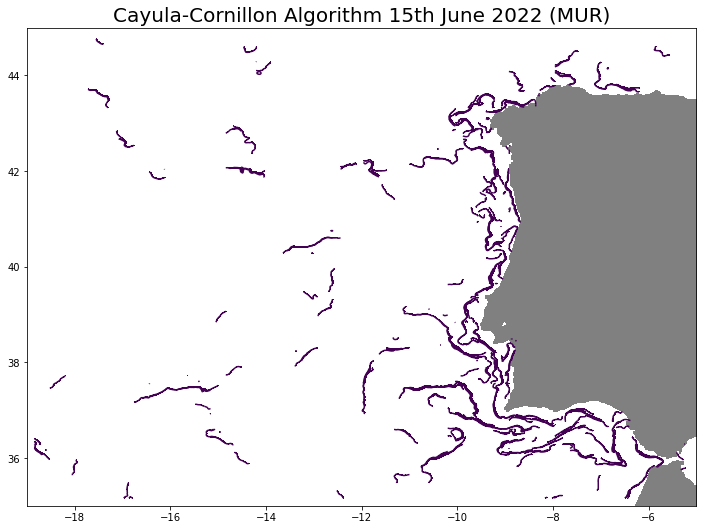

In [71]:
CCA_front(june27_2022)

In [38]:
np.unique(cca_frente)

masked_array(data=[0.0, 1.0, --],
             mask=[False, False,  True],
       fill_value=1e+20)